In [91]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
from sklearn.preprocessing import StandardScaler
from tensorflow import keras
from tensorflow import nn

In [92]:
mpl.rcParams['figure.figsize'] = (15,9)
mpl.rcParams['font.size'] = 18

# data inputation

In [93]:
df = pd.read_csv('raw_sales.csv')
df.head()

,datesold,postcode,price,propertyType,bedrooms
0,2007-02-07 00:00:00,2607,525000,house,4
1,2007-02-27 00:00:00,2906,290000,house,3
2,2007-03-07 00:00:00,2905,328000,house,3
3,2007-03-09 00:00:00,2905,380000,house,4
4,2007-03-21 00:00:00,2906,310000,house,3


# data analysis

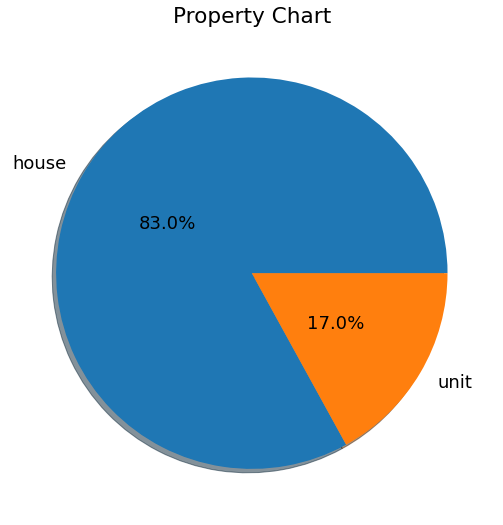

In [94]:
property_type_percentage = data['propertyType'].value_counts()
ax = plt.subplots()
ax = plt.pie(x=property_type_percentage, autopct="%.1f%%", labels=data['propertyType'].value_counts().keys(), pctdistance=0.5,shadow=True )
ax = plt.title('Property Chart')
plt.show()

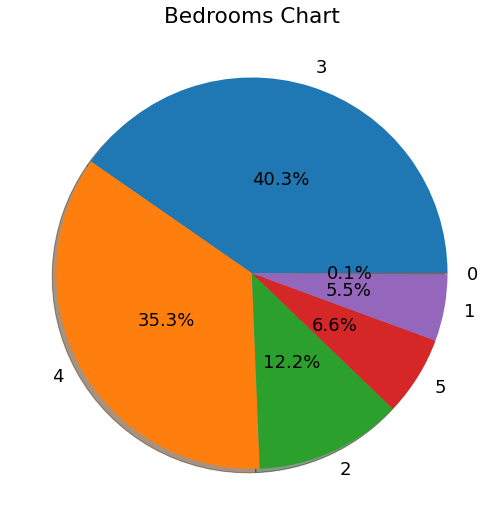

In [95]:
bedrooms_percentage = data['bedrooms'].value_counts()
ax = plt.subplots()
ax = plt.pie(x=bedrooms_percentage, autopct="%.1f%%", labels=data['bedrooms'].value_counts().keys(), pctdistance=0.5,shadow=True )
ax = plt.title('Bedrooms Chart')
plt.show()

In [96]:
df.describe()

,postcode,price,bedrooms
count,29580.000000,2.958000e+04,29580.000000
mean,2730.249730,6.097363e+05,3.250169
std,146.717292,2.817079e+05,0.951275
min,2600.000000,5.650000e+04,0.000000
25%,2607.000000,4.400000e+05,3.000000
50%,2615.000000,5.500000e+05,3.000000
75%,2905.000000,7.050000e+05,4.000000
max,2914.000000,8.000000e+06,5.000000


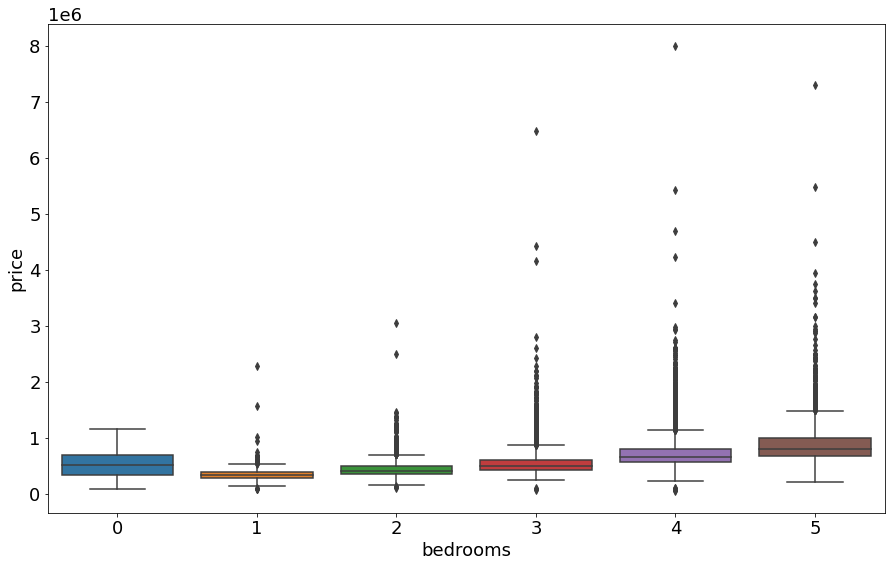

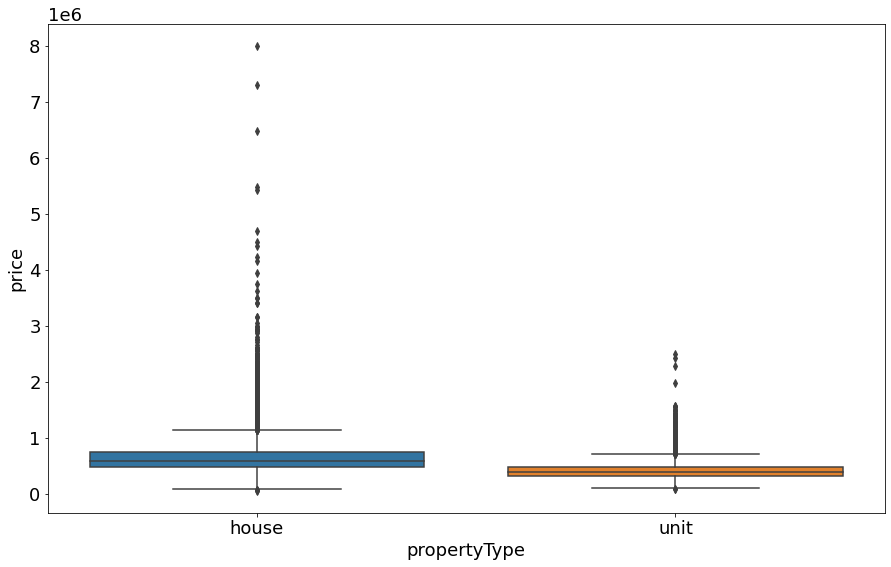

In [97]:
sns.boxplot(x="bedrooms", y="price", data=df)
plt.show()

sns.boxplot(x="propertyType", y="price", data=df)
plt.show()

# data cleaning and processing

In [98]:
df_grouped = df.copy()
df_grouped['count'] = 1

In [99]:
df_grouped['datesold'] = pd.to_datetime(df_grouped['datesold'])
df_grouped = df_grouped.sort_values(by=['datesold'])
df_grouped['month'] = df_grouped['datesold'].dt.month
df_grouped['year'] = df_grouped['datesold'].dt.year
df_grouped['date'] = df_grouped.apply(lambda x: str(x['year']) + '/' + "{:02d}".format(x['month']), axis = 1)

In [100]:
import itertools

# This function will create a "dummy" sale for every month, type of propert and number of bedrooms
def add_group_row(df, columns):
    value_counts_columns = []
    for column in columns:
        value_counts_columns.append(df[column].value_counts().index)
    list_combinations = list(itertools.product(*value_counts_columns))
    for index, row in enumerate(list_combinations):
        list_combinations[index] = [i for i in row]
        list_combinations[index].append(0)
        list_combinations[index].append(1)
    return list_combinations

columns = ['date','propertyType','bedrooms']
rows_to_add = add_group_row(df_grouped, columns)

In [101]:
columns_names = ['date','propertyType','bedrooms', 'price', 'count']
df_rows_to_add = pd.DataFrame(rows_to_add, columns=columns_names)
df_rows_to_add.head()

,date,propertyType,bedrooms,price,count
0,2017/11,house,3,0,1
1,2017/11,house,4,0,1
2,2017/11,house,2,0,1
3,2017/11,house,5,0,1
4,2017/11,house,1,0,1


In [102]:
df_grouped = df_grouped[columns_names]
df_grouped.head()

,date,propertyType,bedrooms,price,count
0,2007/02,house,4,525000,1
1,2007/02,house,3,290000,1
2,2007/03,house,3,328000,1
3,2007/03,house,4,380000,1
4,2007/03,house,3,310000,1


In [104]:
df_grouped_new = pd.concat([df_grouped, df_rows_to_add])
df_grouped_new = df_grouped_new.reset_index(drop=True)
df_grouped_new

,date,propertyType,bedrooms,price,count
0,2007/02,house,4,525000,1
1,2007/02,house,3,290000,1
2,2007/03,house,3,328000,1
3,2007/03,house,4,380000,1
4,2007/03,house,3,310000,1
...,...,...,...,...,...
31375,2007/05,unit,4,0,1
31376,2007/05,unit,2,0,1
31377,2007/05,unit,5,0,1
31378,2007/05,unit,1,0,1


In [105]:
df_grouped_new = df_grouped_new.groupby(by=['date', 'propertyType', 'bedrooms']).sum()
df_grouped_new['price_mean'] = df_grouped_new.apply(lambda x: x['price'] if x['count'] == 1 else x['price'] / (x['count'] - 1), axis= 1)
df_grouped_new.head()

price  count  price_mean
date    propertyType bedrooms                           
2007/02 house        0              0      1         0.0
                     1              0      1         0.0
                     2              0      1         0.0
                     3         290000      2    290000.0
                     4         525000      2    525000.0

In [106]:
first_date = df_grouped_new.index[0][0]
year, month = first_date.split('/')
first_year, first_month = int(year), int(month)
last_date = df_grouped_new.index[-1][0]
year, month = last_date.split('/')
last_year, last_month = int(year), int(month)

In [107]:
value_counts_property = df_grouped['propertyType'].value_counts().index
value_counts_bedrooms = df_grouped['bedrooms'].value_counts().index

#Combine all the values from value_counts_property and value_counts_bedrooms
first_indexes = list(itertools.product([first_date],value_counts_property, value_counts_bedrooms))

# This function replace all the initial values of each type of property if they're 0 with the closeset month with any sale
# whith the same type of property
for index in first_indexes:
    # Verify if the first element just have one count, meaning it's just the dummy we putted before
    if df_grouped_new.loc[index]['count'] == 1:
        origin_property_type = index[1]
        origin_bedrooms = index[2]
        # search for the most recent sale of the same type to replace in the price_mean
        for year in range(first_year, last_year + 1):
            begin_month = 1
            end_month = 12
            if year == first_year:
                begin_month = first_month + 1
            elif year == last_year:
                end_month = last_month
            for month in range(begin_month, end_month + 1):
                current_date = str(year) + '/' + "{:02d}".format(month)
                current_row = df_grouped_new.loc[(current_date, origin_property_type, origin_bedrooms)]
                if current_row['price_mean'] > 0:
                    df_grouped_new.at[index, 'price_mean'] = current_row['price_mean']
                    break
            if df_grouped_new.loc[index]['price_mean'] > 0:
                break
            
df_grouped_new.head()

price  count  price_mean
date    propertyType bedrooms                           
2007/02 house        0              0      1    415000.0
                     1              0      1    327000.0
                     2              0      1    320000.0
                     3         290000      2    290000.0
                     4         525000      2    525000.0

In [108]:
from datetime import datetime
from dateutil.relativedelta import relativedelta

# Function to make a mean between the current month and the previous one
# and to replace any zeros with the previous value of price_mean
for index in df_grouped_new.index:
    if index[0] == first_date:
        continue
    date_obj = datetime.strptime(index[0], '%Y/%m')
    previous_date_obj = date_obj - relativedelta(months=1)
    previous_date_str = str(previous_date_obj.year) + '/' + "{:02d}".format(previous_date_obj.month)
    previous_index = (previous_date_str, index[1], index[2])
    if df_grouped_new.loc[index]['count'] == 1:
        df_grouped_new.at[index, 'price_mean'] = df_grouped_new.loc[previous_index]['price_mean']
    else:
         df_grouped_new.at[index, 'price_mean'] = (df_grouped_new.loc[previous_index]['price_mean']
                                                + df_grouped_new.loc[index]['price_mean'])/2

df_grouped_new.head(20)

price  count  price_mean
date    propertyType bedrooms                           
2007/02 house        0              0      1    415000.0
                     1              0      1    327000.0
                     2              0      1    320000.0
                     3         290000      2    290000.0
                     4         525000      2    525000.0
                     5              0      1    667500.0
        unit         0              0      1     90000.0
                     1              0      1    351000.0
                     2              0      1    300000.0
                     3              0      1    480000.0
                     4              0      1    550000.0
                     5              0      1   1490000.0
2007/03 house        0              0      1    415000.0
                     1              0      1    327000.0
                     2              0      1    320000.0
                     3         638000      3    304500.0
                     4         380000      2    452500.0
                     5              0      1    667500.0
        unit         0              0      1     90000.0
                     1              0      1    351000.0

In [109]:
window = 5

In [110]:
df_grouped_chaged = df_grouped_new.reset_index().sort_values(by=['propertyType', 'bedrooms', 'date'])
feature, target = [], []
bedrooms =  df_grouped_chaged.iloc[0]['bedrooms']
# This value is the window size we are using
index = window
while(index < df_grouped_chaged.shape[0]):
    if bedrooms != df_grouped_chaged.iloc[index]['bedrooms']:
        bedrooms = df_grouped_chaged.iloc[index]['bedrooms']
        index = index + window
    feature.append(df_grouped_chaged.iloc[index - window: index]['price_mean'].to_numpy())
    target.append(df_grouped_chaged.iloc[index][['price_mean', 'date']].to_numpy())
    index = index + 1
feature = np.array(feature)
target = np.array(target)       

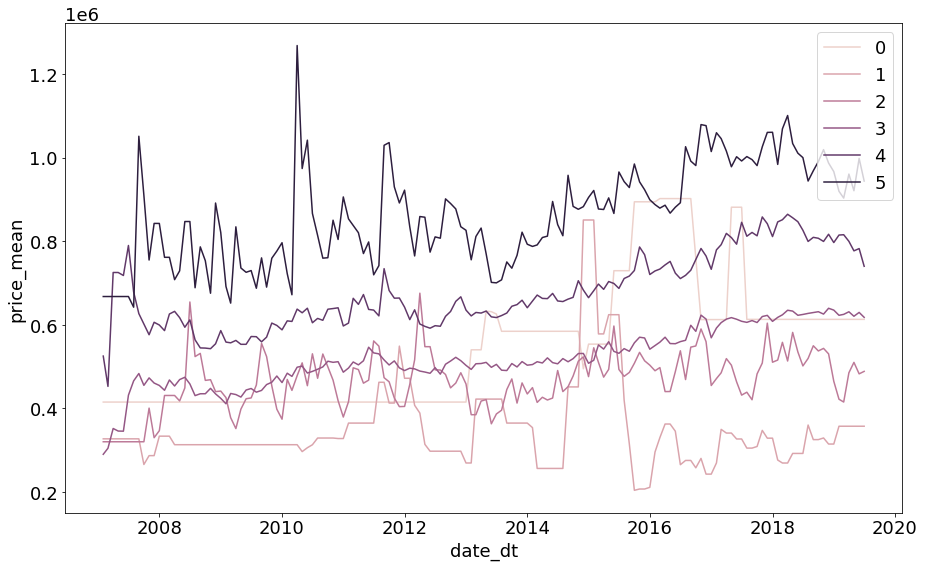

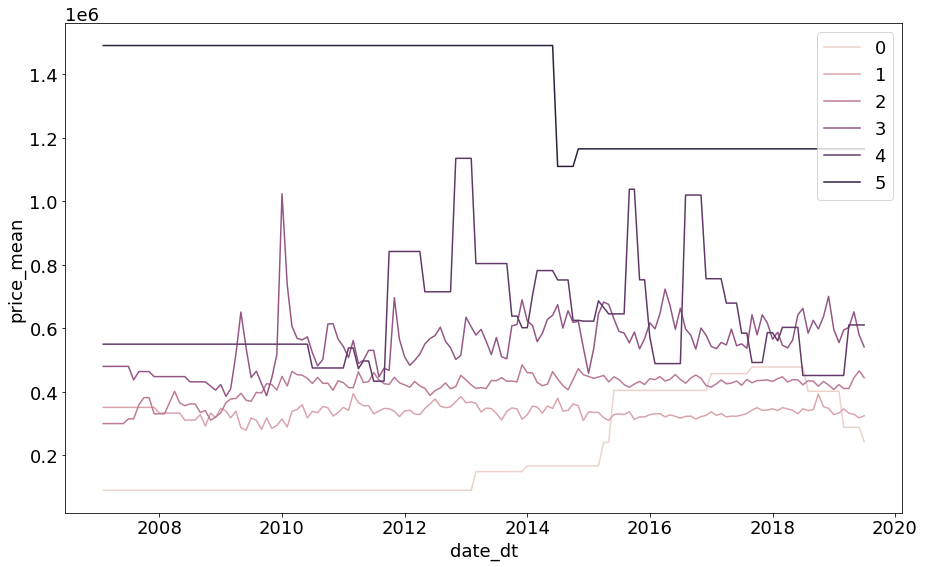

In [111]:
df_aux = df_grouped_new.reset_index()
df_aux['date_dt'] = pd.to_datetime(df_aux['date'], format='%Y/%m') 
sns.lineplot(data = df_aux.query('propertyType == "house"'), x = 'date_dt', y = 'price_mean', hue = 'bedrooms')
plt.legend(loc='upper right')
plt.show()

sns.lineplot(data = df_aux.query('propertyType == "unit"'), x = 'date_dt', y = 'price_mean', hue = 'bedrooms')
plt.legend(loc='upper right')
plt.show()


# regression model

In [112]:
size_test_perc = 0.9

In [113]:
size_test = int(df_grouped['date'].value_counts().index.shape[0] * size_test_perc)
separation_date = df_grouped['date'].value_counts().index.sort_values()[size_test]

In [114]:
x_train, y_train, x_test, y_test = [], [], [], []
for i,t in enumerate(target):
    if t[1] <= separation_date:
        x_train.append(feature[i])
        y_train.append(target[i][0])
    else:
        x_test.append(feature[i])
        y_test.append(target[i][0])

In [115]:
x_train, x_test = np.array(x_train), np.array(x_test)
y_train, y_test = np.array(y_train).reshape(-1, 1), np.array(y_test).reshape(-1, 1)

In [116]:
scaler_feature = StandardScaler()
scaler_feature.fit(x_train)
x_train = scaler_feature.transform(x_train)
x_test = scaler_feature.transform(x_test)

# Reshaping features for the LSTM
x_train, x_test = x_train.reshape(-1,window,1), x_test.reshape(-1,window,1)

scaler_target = StandardScaler()
scaler_target.fit(y_train)
y_train = scaler_target.transform(y_train)
y_test = scaler_target.transform(y_test)

In [117]:
model = keras.Sequential()
model.add(keras.layers.LSTM(units = 128, return_sequences = True, input_shape=(x_train.shape[1], x_train.shape[2])))
model.add(keras.layers.Dropout(0.2))

model.add(keras.layers.LSTM(units = 128))
model.add(keras.layers.Dropout(0.25))
model.add(keras.layers.Dense(1))

model.compile(loss='mean_squared_error', optimizer='RMSProp')
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 5, 128)            66560     
_________________________________________________________________
dropout_6 (Dropout)          (None, 5, 128)            0         
_________________________________________________________________
lstm_5 (LSTM)                (None, 128)               131584    
_________________________________________________________________
dropout_7 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 129       
Total params: 198,273
Trainable params: 198,273
Non-trainable params: 0
_________________________________________________________________


In [80]:
result = model.fit(x_train,y_train,validation_data=(x_test,y_test),epochs=10)

Epoch 1/10
50/50 [==============================] - 7s 38ms/step - loss: 0.2713 - val_loss: 0.0329
Epoch 2/10
50/50 [==============================] - 1s 14ms/step - loss: 0.0651 - val_loss: 0.0220
Epoch 3/10
50/50 [==============================] - 1s 14ms/step - loss: 0.0601 - val_loss: 0.0212
Epoch 4/10
50/50 [==============================] - 1s 12ms/step - loss: 0.0574 - val_loss: 0.0162
Epoch 5/10
50/50 [==============================] - 1s 13ms/step - loss: 0.0685 - val_loss: 0.0273
Epoch 6/10
50/50 [==============================] - 1s 13ms/step - loss: 0.0476 - val_loss: 0.0135
Epoch 7/10
50/50 [==============================] - 1s 13ms/step - loss: 0.0468 - val_loss: 0.0197
Epoch 8/10
50/50 [==============================] - 1s 12ms/step - loss: 0.0448 - val_loss: 0.0140
Epoch 9/10
50/50 [==============================] - 1s 13ms/step - loss: 0.0341 - val_loss: 0.0177
Epoch 10/10
50/50 [==============================] - 1s 12ms/step - loss: 0.0384 - val_loss: 0.0159


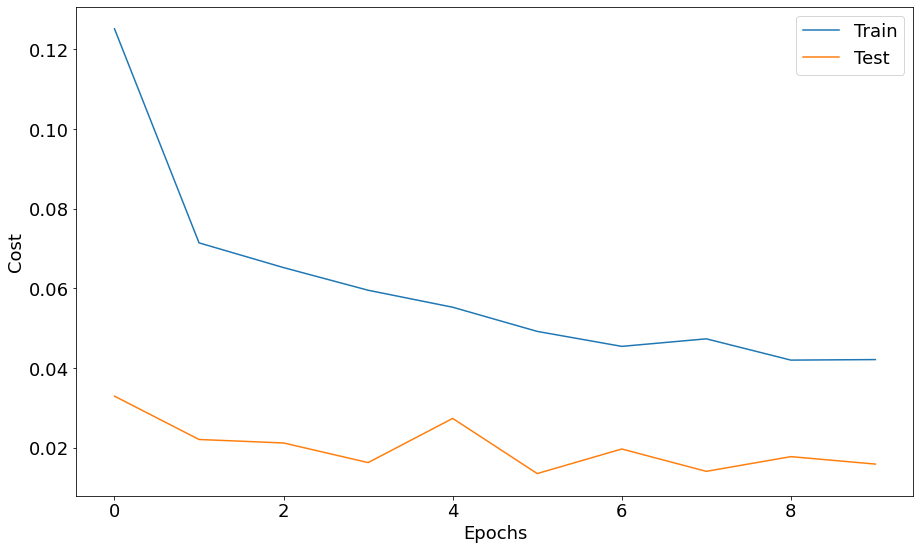

In [81]:
def print_loss(result):
    plt.plot(result.history['loss'])
    plt.plot(result.history['val_loss'])
    plt.legend(['Train', 'Test'])
    plt.xlabel('Epochs')
    plt.ylabel('Cost')
    plt.show()

print_loss(result)

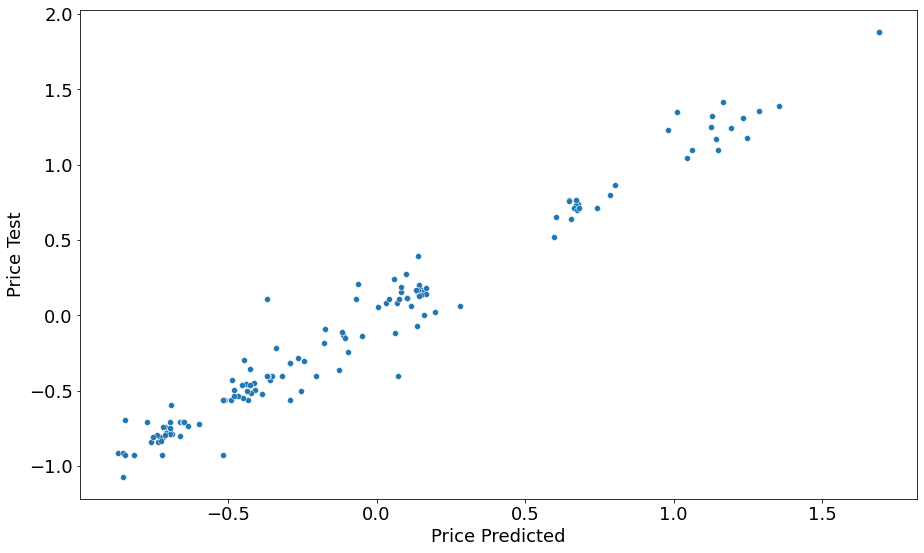

In [83]:
y_predicted = model.predict(x_test)

ax = sns.scatterplot(x=y_predicted[:,0], y=y_test[:,0])
ax.set_ylabel('Price Test')
ax.set_xlabel('Price Predicted')
plt.show()

In [84]:
from sklearn.preprocessing import OneHotEncoder

oe_style = OneHotEncoder()
oe_results = oe_style.fit_transform(df[["propertyType"]])
temp = pd.DataFrame(oe_results.toarray(), columns=oe_style.categories_[0], index=df.index)
df = pd.concat([df, temp], axis=1)
df = df.drop(columns=['propertyType'])
df.head()

,datesold,postcode,price,bedrooms,house,unit
0,2007-02-07 00:00:00,2607,525000,4,1.0,0.0
1,2007-02-27 00:00:00,2906,290000,3,1.0,0.0
2,2007-03-07 00:00:00,2905,328000,3,1.0,0.0
3,2007-03-09 00:00:00,2905,380000,4,1.0,0.0
4,2007-03-21 00:00:00,2906,310000,3,1.0,0.0


In [85]:
df['datesold'] = pd.to_datetime(df['datesold'])
df['month'] = df['datesold'].dt.month
df['year'] = df['datesold'].dt.year
df['day'] = df['datesold'].dt.day

df.head()

,datesold,postcode,price,bedrooms,house,unit,month,year,day
0,2007-02-07,2607,525000,4,1.0,0.0,2,2007,7
1,2007-02-27,2906,290000,3,1.0,0.0,2,2007,27
2,2007-03-07,2905,328000,3,1.0,0.0,3,2007,7
3,2007-03-09,2905,380000,4,1.0,0.0,3,2007,9
4,2007-03-21,2906,310000,3,1.0,0.0,3,2007,21


In [86]:
feature_columns = df.drop(columns=['postcode', 'price', 'datesold', 'day']).columns
feature = df[feature_columns]
target = df['price']

In [87]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(feature , target, 
                                                    shuffle = True, 
                                                    test_size=0.2, 
                                                    random_state=1)

scaler_feature = StandardScaler()
scaler_feature.fit(X_train)
X_train = scaler_feature.transform(X_train)
X_test = scaler_feature.transform(X_test)

y_train, y_test = y_train.values.reshape(-1,1), y_test.values.reshape(-1,1)

scaler_target = StandardScaler()
scaler_target.fit(y_train)
y_train = scaler_target.transform(y_train)
y_test = scaler_target.transform(y_test)

In [88]:
model = keras.Sequential()
model.add(keras.layers.Dense(64, input_dim=X_train.shape[1], activation=nn.relu))
model.add(keras.layers.Dense(64,activation=nn.relu))
model.add(keras.layers.Dropout(0.2))
model.add(keras.layers.Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 64)                384       
_________________________________________________________________
dense_6 (Dense)              (None, 64)                4160      
_________________________________________________________________
dropout_5 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 65        
Total params: 4,609
Trainable params: 4,609
Non-trainable params: 0
_________________________________________________________________


In [89]:
result = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10)

Epoch 1/10
740/740 [==============================] - 1s 1ms/step - loss: 0.7521 - val_loss: 0.7201
Epoch 2/10
740/740 [==============================] - 1s 1ms/step - loss: 0.6450 - val_loss: 0.7212
Epoch 3/10
740/740 [==============================] - 1s 976us/step - loss: 0.7018 - val_loss: 0.7245
Epoch 4/10
740/740 [==============================] - 1s 1ms/step - loss: 0.8195 - val_loss: 0.7195
Epoch 5/10
740/740 [==============================] - 1s 960us/step - loss: 0.7700 - val_loss: 0.7184
Epoch 6/10
740/740 [==============================] - 1s 949us/step - loss: 0.7638 - val_loss: 0.7228
Epoch 7/10
740/740 [==============================] - 1s 945us/step - loss: 0.7468 - val_loss: 0.7187
Epoch 8/10
740/740 [==============================] - 1s 949us/step - loss: 0.7354 - val_loss: 0.7208
Epoch 9/10
740/740 [==============================] - 1s 955us/step - loss: 0.7478 - val_loss: 0.7197
Epoch 10/10
740/740 [==============================] - 1s 947us/step - loss: 0.6631 - va

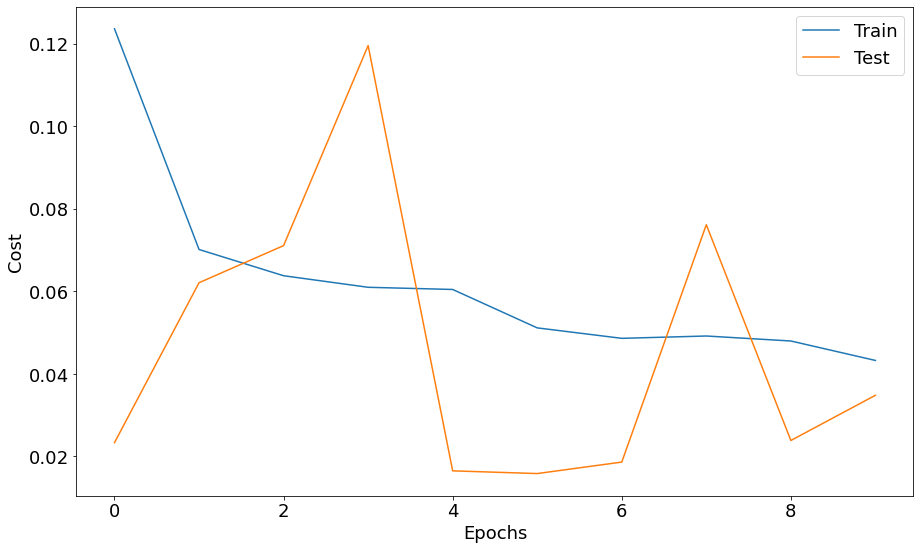

In [52]:
print_loss(result)

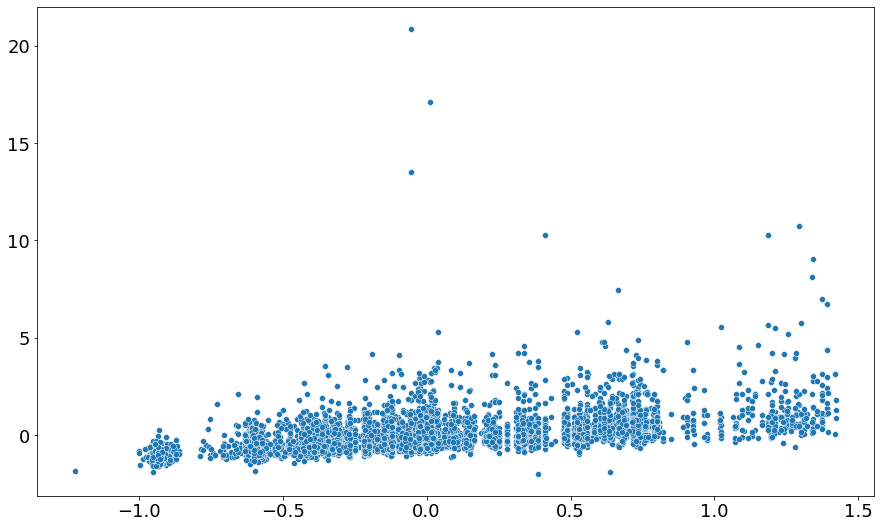

In [90]:
y_predicted = model.predict(X_test)

ax = sns.scatterplot(x=y_predicted[:,0], y=y_test[:,0])